In [1]:
import time
import numpy as np
import scipy.ndimage.filters as nd

from skimage import io, color, transform

from utils import nms, plot_circles

In [2]:
def create_empty_scale_space(img, n_scales):
    M, N, *_ = img.shape
    return np.empty((M, N, n_scales))

In [3]:
def create_log_filter(img, sigma, is_norm=True):
    log_filter = nd.gaussian_laplace(img, sigma=sigma)  # convolve the filter with the image
    if is_norm:
        return (sigma ** 2) * log_filter
    return log_filter

In [4]:
def increase_log_filter_size(gray_img, n_scales, sigma=2, k=np.sqrt(2)):
    scale_space = create_empty_scale_space(gray_img, n_scales)
    
    for n in range(n_scales):
        scaled_sigma = sigma * k ** n
        log_filter_sq = create_log_filter(gray_img, scaled_sigma, is_norm=True) ** 2  # square the filter response
        scale_space[:, :, n] = log_filter_sq
    
    return scale_space

In [5]:
def downsample(gray_img, n_scales, sigma=2, k=np.sqrt(2)):
    M, N = gray_img.shape
    scale_space = create_empty_scale_space(gray_img, n_scales)
    
    for n in range(n_scales):
        scaled_multiplier = k ** n
        scaled_img = transform.resize(
            gray_img, output_shape=[int(M/scaled_multiplier), int(N/scaled_multiplier)]
        )  # downsample
        log_filter_sq = create_log_filter(scaled_img, sigma=sigma, is_norm=True) ** 2  # square the filter response
        scale_space[:, :, n] = transform.resize(log_filter_sq, [M, N])  # upsample

    return scale_space

In [6]:
def nms_2d(filter_response):
    n_scales = filter_response.shape[2]
    nms_2d_space = create_empty_scale_space(filter_response, n_scales)
    
    for n in range(n_scales):
#         max_filter = nd.rank_filter(filter_response[:, :, n], rank=-1, footprint=np.ones((3, 3)))  # equivalent
        max_filter = nd.maximum_filter(filter_response[:, :, n], footprint=np.ones((3, 3)))
        nms_2d_space[:, :, n] = (max_filter == filter_response[:, :, n]) * filter_response[:, :, n]
        
    return nms_2d_space

In [7]:
def nms_3d(filter_response):
    max_filter = nd.maximum_filter(filter_response, footprint=np.ones((3, 3, filter_response.shape[2])))
    nms_3d_space = (max_filter == filter_response) * filter_response
    return nms_3d_space

In [8]:
def compute_coords_by_scale(nms_space, n_scales, min_distance=10, threshold=0.03):
    coords = [
        nms(nms_space[:, :, n], min_distance=min_distance, threshold=threshold)
        for n in range(n_scales)
    ]
    return coords

In [9]:
def parse_coords(coords):
    cx, cy = [], []
    for layer in coords:
        for a, b in layer:
            cx.append(a)
            cy.append(b)
    return cx, cy

In [10]:
def compute_radii(coords, n_scales, sigma, k):
    radii = []
    for n in range(n_scales):
        scaled_sigma = np.sqrt(2) * sigma * k ** n
        radii += [scaled_sigma for _ in range(len(coords[n]))]
    return radii

In [11]:
def blob_detector(img, params):
    
    gray_img = color.rgb2gray(img)
    
    st = time.time()
    filter_response = increase_log_filter_size(gray_img, params['n_scales'], params['sigma'], params['k'])
    print(f'Time for increasing LoG filter {time.time()-st}')
    
    st = time.time()
    filter_response = downsample(gray_img, params['n_scales'], params['sigma'], params['k'])
    print(f'Time for downsampling {time.time()-st}')

    if params['nms_3d']:
        nms_space = nms_2d(filter_response)
    else:
        nms_space = nms_3d(filter_response)
    
    coords = compute_coords_by_scale(nms_space, params['n_scales'], params['min_distance'], params['threshold'])
    cx, cy = parse_coords(coords)
    
    radii = compute_radii(coords, params['n_scales'], params['sigma'], params['k'])
    
    plot_circles(gray_img, cx, cy, radii)

Time for increasing LoG filter 0.11017107963562012
Time for downsampling 0.09946203231811523


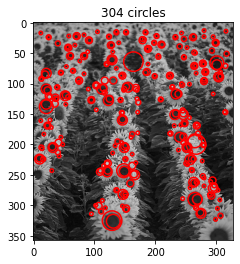

In [24]:
def main(filename='sunflowers.jpg'):

    img = io.imread(filename)
    params = {
        'n_scales': 7,  # 5
        'sigma': 2,  # 2
        'k': np.sqrt(2),
        'min_distance': 10,
        'threshold': 0.03,  # 0.01
        'nms_3d': True
    }
    
    blob_detector(img, params)

main()